## Import

In [27]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import chain

# for reading and displaying images
# from skimage.io import imread
import matplotlib.pyplot as plt
from glob import glob

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.autograd import Function

# models
from src.architectures.resnet import *
from src.architectures.levakov_96 import *
from src.architectures.inception import *
from src.architectures.dinsdale import *

from src.run import *

from torch.optim import *
import torch.optim as optim
from torchsummary import summary
from tensorboardX import SummaryWriter

# CAM
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

from medcam import medcam

## Dataloader
for kFold, it will be run again on the run

In [28]:
from src.dataloader import *

train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

## Load Model

In [29]:
def load_model(model, verbose=True):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Model {model.capitalize()} is selected.')

    if model == 'resnet':
        

        opt = Option()
        model = generate_model(model_depth=opt.model_depth,
                                    n_classes=opt.n_classes,
                                    n_input_channels=opt.n_input_channels,
                                    shortcut_type=opt.shortcut_type,
                                    conv1_t_size=opt.conv1_t_size,
                                    conv1_t_stride=opt.conv1_t_stride,
                                    no_max_pool=opt.no_max_pool,
                                    widen_factor=opt.resnet_widen_factor)

    elif model == 'levakov':
        model = Levakov(task_type='age')

    elif model == 'inception':
        model = Inception3()

    elif model == 'dinsdale':
        model = Dinsdale(1, 1, 2)

    else: return None

    model.to(device)
    if verbose:
        print(summary(model, input_size=(1, 96, 96, 96)))
    
    return model, device

model = 'levakov'
model, device = load_model(model)

Model Levakov is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm3d-1        [-1, 1, 96, 96, 96]               2
            Conv3d-2        [-1, 8, 94, 94, 94]             224
              ReLU-3        [-1, 8, 94, 94, 94]               0
            Conv3d-4        [-1, 8, 92, 92, 92]           1,736
              ReLU-5        [-1, 8, 92, 92, 92]               0
         MaxPool3d-6        [-1, 8, 46, 46, 46]               0
       BatchNorm3d-7        [-1, 8, 46, 46, 46]              16
            Conv3d-8       [-1, 16, 44, 44, 44]           3,472
              ReLU-9       [-1, 16, 44, 44, 44]               0
           Conv3d-10       [-1, 16, 42, 42, 42]           6,928
             ReLU-11       [-1, 16, 42, 42, 42]               0
        MaxPool3d-12       [-1, 16, 21, 21, 21]               0
      BatchNorm3d-13       [-1, 16, 21, 21, 21]              32
          Dr

## Setups

Default Settings

In [30]:
task_type = 'age' # no longer used.
resize = True
scheduler = False
epochs = range(100)
folds = range(10)

Loss & Optimizer

In [31]:
from src.losses import RMSELoss

loss_fn = nn.MSELoss()
lamb = 0.0005
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

Metrics

In [32]:
rmse_fn = RMSELoss()
mae_fn = nn.L1Loss()

In [33]:
model = torch.load('models/2020-12-04_2113_9.632_model.pth')
model.eval()

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm3d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing 

ResNet(
  (conv1): Conv3d(1, 16, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=Tru

In [34]:
model = medcam.inject(model, output_dir="attentio_maps", save_maps=True)

In [8]:
# the target layer you want to visualize
target_layer = model.layer4[0].conv2

# wrapper for class activation mapping. Choose one of the following.
# wrapped_model = CAM(model, target_layer)
# wrapped_model =GradCAM(model, target_layer)
# wrapped_model = GradCAMpp(model, target_layer)
wrapped_model = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)

In [9]:
for i, (x, y) in enumerate(train_loader):
    
    if i < 2:
        x, y = x.to(device), y.to(device)
    
    else:
        break
        
tensor = x[0][None, ...].cuda()

In [23]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485],
   std=[0.229]
)

preprocess = transforms.Compose([
    normalize
])

In [26]:
# convert image to tensor
tensor = preprocess(x[0])

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

ValueError: Expected tensor to be a tensor image of size (C, H, W). Got tensor.size() = torch.Size([1, 141, 172, 110]).

In [10]:
cam, idx = wrapped_model(tensor)

predicted class ids 0	 probability 1.0


In [12]:
cam.shape

torch.Size([1, 1, 9, 6, 4])

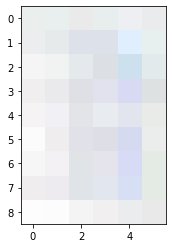

In [14]:
# visualize only cam
imshow(cam.squeeze().cpu().numpy(), alpha=0.5, cmap='jet')

In [18]:
# reverse normalization for display
img = reverse_normalize(tensor[0])

In [22]:
heatmap = visualize(img, cam[0].cpu())

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6lylwdcz\opencv\modules\imgproc\src\colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'cv::colormap::ColorMap::operator ()'


In [29]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply